In [2]:
import os
import json

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np

import ast
import math

## Setup for all figures

In [3]:
BASE_DIR = '..'
RESULTS_DIR = os.path.join(BASE_DIR,'cami2_benchmark', 'model_results', 'parsed_results') #v4 has c10 and c20 contamination threshold
RESULTS_DIR_PHENO = os.path.join(BASE_DIR, "phenotype_mil", "binning_results", "parsed_results")

OUT_DIR = os.path.join(BASE_DIR, 'figures')

DATASET_ORDER = [
    'airways_short',
    'gastro_short',
    'oral_short',
    'urogenital_short',
    'skin_short',
    'marine_short',
    'plant_short',
    'metahit'
]

#main results
MODELS = ['dnaberth_400kv2', 'dnaberth_2mv4','dnaberth_2mv5', 'dnaberts', 'dnabert2', 'tnf',  'dna2vec']
MODEL_NAMES = ['DNABERT-H-400k', 'DNABERT-H-2M', 'DNABERT-H-2M-R', 'DNABERT-S', 'DNABERT-2', 'TNF', 'DNA2Vec']

completeness_levels = ['>90%', '>80%', '>70%', '>60%', '>50%']
colors = ['#005f5f', '#008c8c', '#66c2c2', '#a0e6e6', '#d9fafa']

#other dnaberth versions
# MODELS = ['dnaberth_400k', 'dnaberth_2mv1', 'dnaberth_2mv2', 'dnaberth_400kv2', 'dnaerth_2mv3', 'dnaberts', 'dnabert2', 'dnabert2random', 'tnf', 'tnfkernel', 'dna2vec']
# MODEL_NAMES = ['DNABERT-H 400k', 'DNABERT-H 2MV1', 'DNABERT-H 2MV2', 'DNABERT-H 400kV2', 'DNABERT-H 2MV3' 'DNABERT-S', 'DNABERT-2', 'DNABERT2-Random', 'TNF', 'TNF-Kernel', 'DNA2Vec']

## Single CHECKM2

In [3]:
def parse_quality_report(file_path):
    """Parses a CheckM2 quality report and extracts completeness & contamination."""
    df = pd.read_csv(file_path, sep="\t")
    df = df[df["Contamination"] < 5]
    return df["Completeness"].values


def process_all_reports(model_results_dir):
    """Walks through the model_results_dir to collect all models and datasets."""
    data = {}

    for dataset in os.listdir(model_results_dir):
        dataset_path = os.path.join(model_results_dir, dataset, "checkm2")
        if not os.path.isdir(dataset_path):
            continue

        for model in os.listdir(dataset_path):
            report_path = os.path.join(dataset_path, model, "quality_report.tsv")
            if not os.path.isfile(report_path):
                continue

            completeness_values = parse_quality_report(report_path)
            bin_counts = [
                int(np.sum(completeness_values >= b)) for b in ['>90%', '>80%', '>70%', '>60%', '>50%']
            ]

            if dataset not in data:
                data[dataset] = {}
            data[dataset][model] = bin_counts

    return data

In [ ]:
path = os.path.join(f'dnaberthv4/quality_report_.tsv')
k = parse_quality_report(path)
bin_counts = [
            int(np.sum(k >= b)) for b in [90, 80, 70, 60, 50]
]
print(bin_counts)

## CheckM2 Results

In [85]:
with open(os.path.join(RESULTS_DIR, 'parsed_checkm2_results.json'), 'r') as f:
    checkm2_data = json.load(f)
    
na_metahit = ['vamb_results', 'taxvamb_results', 'comebin_results']
if 'metahit' in checkm2_data:
    for method in na_metahit:
        if method not in checkm2_data['metahit']:
            checkm2_data['metahit'][method] = [-1] * len(checkm2_data['metahit']['dnabert2_results'])
            
na_marine = ['comebin_results']
if 'marine_short' in checkm2_data:
    for method in na_marine:
        if method not in checkm2_data['marine_short']:
            checkm2_data['marine_short'][method] = [-1] * len(checkm2_data['marine_short']['dnabert2_results'])
            

results_to_remove = {'dnaberth_400k_results', 'dnaberth_2mv1_results', 'dnaberth_2mv2_results', 'dnabert2random_results', 'tnfkernel_results'}
#results_to_remove = {'dnaberth_400k_results', 'dnaberth_2mv1_results', 'dnaberth_2mv2_results'} #for cami2appendix
for dataset in checkm2_data.values():
    for key in results_to_remove:
        dataset.pop(key, None)

In [86]:
cami2_model_names = {
    'vamb_results': 'VAMB',
    'taxvamb_results': 'TaxVAMB',
    'comebin_results': 'Comebin',
    #'dnaberth_400k_results': 'DNABERT-H 400k',
    #'dnaberth_2mv1_results': 'DNABERT-H 2MV1',
    #'dnaberth_2mv2_results': 'DNABERT-H 2MV2',
    'dnaberth_400kv2_results': 'DNABERT-H-400k',
    'dnaberth_2mv4_results': 'DNABERT-H-2M',
    'dnaberth_2mv5_results': 'DNABERT-H-2M-R',
    'dnaberts_results': 'DNABERT-S',
    'dnabert2_results': 'DNABERT-2',
    'dnabert2random_results': 'DNABERT2-Random',
    'tnf_results': 'TNF',
    'tnfkernel_results': 'TNF-Kernel',
    'dna2vec_results': 'DNA2Vec'
}

C:\Users\ah140\AppData\Local\Temp\ipykernel_5748\4263660088.py:79: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


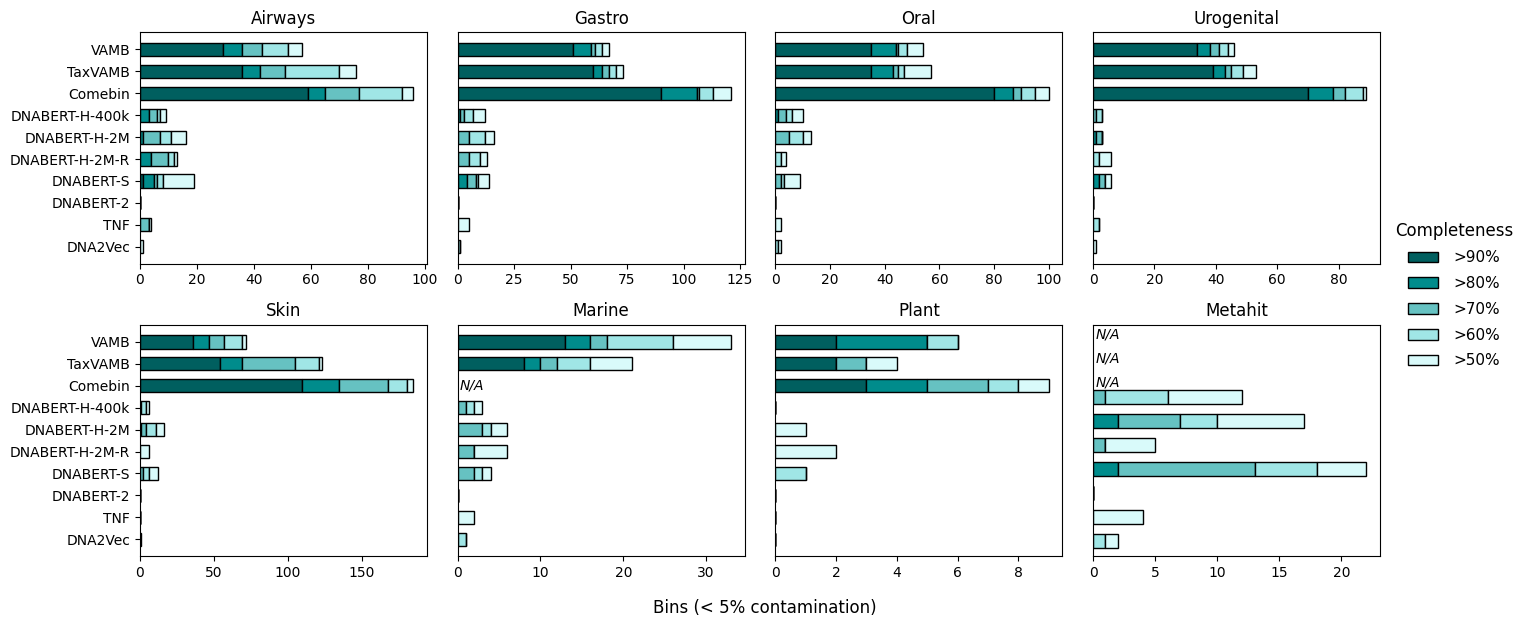

In [ ]:
n_cols = 4
n_rows = int((len(DATASET_ORDER) + n_cols - 1) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6), constrained_layout=True)
axes = axes.flatten()

max_total = 0

for idx, domain in enumerate(DATASET_ORDER):
    methods = checkm2_data[domain]
    
    # Filter and sort method names based on custom order
    method_names = [m for m in cami2_model_names.keys() if m in methods]
    y_pos = list(range(len(method_names)))
    
    left = [0] * len(method_names)
    ax = axes[idx]
    
    for i, comp in enumerate(completeness_levels):
        if domain not in ['marine_short','metahit']:
            if i == 0:
                values = [methods[m][i] for m in method_names]
            else:
                values = [methods[m][i] - methods[m][i - 1] for m in method_names]
            
            ax.barh(y_pos, values, left=left, color=colors[i], edgecolor='black', height=0.6)
            left = [l + v for l, v in zip(left, values)]
            
        elif domain in ['marine_short','metahit']:
            values = []
            for m in method_names:
                if methods[m][0] == -1:
                    values.append(None)
                elif i == 0:
                    values.append(methods[m][i])
                else:
                    values.append(methods[m][i] - methods[m][i - 1])

            for j, val in enumerate(values):
                if val is not None:
                    ax.barh(j, val, left=left[j], color=colors[i], edgecolor="black", height=0.6)
                    left[j] += val

    # For metahit: show "N/A" if method data is -1
    if domain in ['metahit']:
        for j, m in enumerate(method_names):
            if methods[m][0] == -1:
                ax.text(1.2, j+0.4, "N/A", va="center", ha="center", fontsize=10, color="black", fontstyle="italic")
    if domain in ['marine_short']:
        for j, m in enumerate(method_names):
            if methods[m][0] == -1:
                ax.text(1.7, j, "N/A", va="center", ha="center", fontsize=10, color="black", fontstyle="italic")


    ax.set_title(domain.replace('_short', '').capitalize())

    if idx % n_cols == 0:
        ax.set_yticks(y_pos)
        ax.set_yticklabels([cami2_model_names.get(m, m.replace('_results', '')) for m in method_names])
    else:
        ax.set_yticks(y_pos)
        ax.set_yticklabels([])
        ax.tick_params(left=False)

    ax.invert_yaxis()
    max_total = max(max_total, max(left))

for i in range(len(DATASET_ORDER), len(axes)):
    fig.delaxes(axes[i])

legend_labels = [f'{level}' for level in completeness_levels]  # Do NOT reverse
legend_patches = [Patch(facecolor=c, edgecolor='black', label=l) for c, l in zip(colors, legend_labels)]

fig.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(0.99, 0.5),
           title='Completeness', frameon=False, handletextpad=1, labelspacing=0.7, fontsize=11, title_fontsize=12)

fig.text(0.55, -0.03, "Bins (< 5% contamination)", fontsize=12, ha='center')

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "cami2_main.svg"), bbox_inches='tight')
plt.show()

In [108]:
with open(os.path.join(RESULTS_DIR_PHENO, 'parsed_checkm2_results.json'), 'r') as f:
    checkm2_data_pheno = json.load(f)

In [115]:
cami2_model_names_pheno = {
    'vamb_results': 'VAMB',
    'dnaberth_2mv4_results': 'DNABERT-H-2M',
    'dnaberts_results': 'DNABERT-S'
}

dataset_namemap_pheno = {'UNSEEN': 'WEGOVY',
                         'T2D-EW': 'T2D-EUW'}

In [116]:
checkm2_data_pheno

{'UNSEEN': {'dnaberth_2mv4_results': [0, 1, 4, 6, 12],
  'dnaberts_results': [0, 1, 5, 12, 18],
  'vamb_results': [81, 140, 185, 211, 231]},
 'T2D-EW': {'dnaberth_2mv4_results': [0, 0, 0, 1, 3],
  'dnaberts_results': [0, 0, 0, 1, 9],
  'vamb_results': [151, 253, 308, 349, 385]}}

C:\Users\ah140\AppData\Local\Temp\ipykernel_5748\3233109225.py:51: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


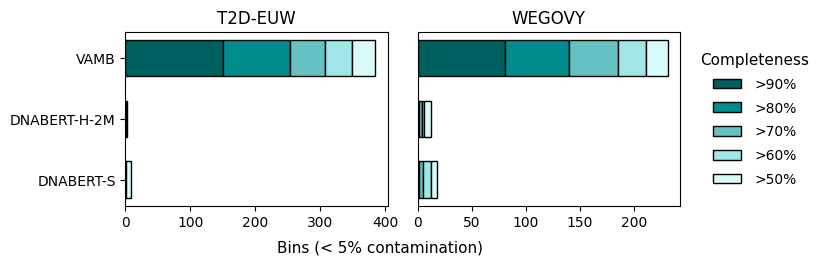

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7, 2.5), constrained_layout=True)
axes = axes.flatten()

max_total = 0

for idx, domain in enumerate(['T2D-EW', 'UNSEEN']):
    methods = checkm2_data_pheno[domain]
    
    # Filter and sort method names based on custom order
    method_names = [m for m in cami2_model_names_pheno.keys() if m in methods]
    y_pos = list(range(len(method_names)))
    
    left = [0] * len(method_names)
    ax = axes[idx]
    
    for i, comp in enumerate(completeness_levels):

        if i == 0:
            values = [methods[m][i] for m in method_names]
        else:
            values = [methods[m][i] - methods[m][i - 1] for m in method_names]
        
        ax.barh(y_pos, values, left=left, color=colors[i], edgecolor='black', height=0.6)
        left = [l + v for l, v in zip(left, values)]
            

    ax.set_title(dataset_namemap_pheno[domain])

    if idx % 2 == 0:
        ax.set_yticks(y_pos)
        ax.set_yticklabels([cami2_model_names.get(m, m.replace('_results', '')) for m in method_names])
    else:
        ax.set_yticks(y_pos)
        ax.set_yticklabels([])
        ax.tick_params(left=False)

    ax.invert_yaxis()
    max_total = max(max_total, max(left))

for i in range(len(DATASET_ORDER), len(axes)):
    fig.delaxes(axes[i])

legend_labels = [f'{level}' for level in completeness_levels]  # Do NOT reverse
legend_patches = [Patch(facecolor=c, edgecolor='black', label=l) for c, l in zip(colors, legend_labels)]

fig.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(0.99, 0.5),
           title='Completeness', frameon=False, handletextpad=1, labelspacing=0.7, fontsize=10, title_fontsize=11)

fig.text(0.55, -0.03, "Bins (< 5% contamination)", fontsize=11, ha='center')

plt.tight_layout()
#plt.savefig(os.path.join(OUT_DIR, "cami2_pheno.svg"), bbox_inches='tight')
plt.show()

## KNN Histograms

In [88]:
with open(os.path.join(RESULTS_DIR, 'parsed_knn_histograms.json'), 'r') as f:
    knn_data = json.load(f)

In [89]:
def modify_histogram_data(dataset_dict):
    """
    Adds a 0 and 1 to the start and end of the pairsim_vector and bin_vector
    """
    
    for dataset_name, models in dataset_dict.items():
        for model_name, model_data in models.items():
            # Modify pairsim_vector by adding 0 at the start and 1 at the end
            if "pairsim_vector" in model_data:
                model_data["pairsim_vector"] = [0] + model_data["pairsim_vector"] + [1]
            
            # Modify bin_vector by adding 0 at both the start and end
            if "bin_vector" in model_data:
                model_data["bin_vector"] = [0] + model_data["bin_vector"] + [0]

    return dataset_dict

In [90]:
knn_data = {k: knn_data[k] for k in DATASET_ORDER if k in knn_data}

In [91]:
def plot_histograms(dataset_dict, selected_models: list, selected_MODEL_NAMES:list, save_name:str):
    """
    Plots histograms for the selected models of each dataset.

    Args:
        dataset_dict (dict): Dictionary where the key is the dataset name and value is a 
                             dictionary of models and associated histogram data.
    """
    dataset_dict = modify_histogram_data(dataset_dict)
    color_thres = 'darkred'
    n_datasets = len(dataset_dict)
    n_models = len(selected_models)

    if len(selected_models) == 3:
        fig, axes = plt.subplots(n_datasets, n_models, figsize=(10, 1.7 * n_datasets), squeeze=False)
    else:
        fig, axes = plt.subplots(n_datasets, n_models, figsize=(4, 1.7 * n_datasets), squeeze=False)

    for i, (dataset_name, models) in enumerate(dataset_dict.items()):
        for j, (model_name, model_namepretty) in enumerate(zip(selected_models, selected_MODEL_NAMES)):

            ax = axes[i, j]

            x_data = models[model_name].get("pairsim_vector", None)
            y_data = models[model_name].get("bin_vector", None)
            threshold = models[model_name].get("knn_threshold", None)
            k = models[model_name].get("k", None)
            p = models[model_name].get("p", None)

            #histogram
            ax.plot(x_data, y_data, color='steelblue', linestyle='-', linewidth=2)
            ax.fill_between(x_data, y_data, color='steelblue', alpha=0.3)

            # Add k, p box
            ax.text(
                0.04, 0.96, f'k={k}, p={p}', 
                transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='left',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='gray', alpha=0.6)
            )

            # Threshold line and annotation
            ax.axvline(threshold, color=color_thres, linestyle='--', label=f'Threshold: {threshold:.2f}')
            if model_name in ['aa']:
                ax.text(threshold + 0.04, 0.8 * max(ax.get_ylim()), f'{threshold:.2f}', color=color_thres, fontsize=11, ha='left')
                ax.plot([threshold + 0.04, threshold + 0.04 + 0.11], [0.78 * max(ax.get_ylim())] * 2, color=color_thres, lw=1)
            else:
                ax.text(threshold - 0.09, 0.8 * max(ax.get_ylim()), f'{threshold:.2f}', color=color_thres, fontsize=11, ha='center')
                ax.plot([threshold - 0.04, threshold - 0.04 - 0.11], [0.78 * max(ax.get_ylim())] * 2, color=color_thres, lw=1)

            # Y-axis formatting
            y_min, y_max = ax.get_ylim()
            y_ticks = np.linspace(y_min, y_max, 4)
            ax.set_yticks(y_ticks)
            ax.set_yticklabels([f'{tick / 100:.5f}' for tick in y_ticks])
            ax.grid(True, linestyle='--', alpha=0.5)

            # Add column titles
            if i == 0:
                ax.set_title(model_namepretty, fontsize=13, pad=12)

        # Add row labels on the far left
        #fig.text(-0.01, (1 - (i + 0.5) / n_datasets), dataset_name.replace('_short','').capitalize(), ha='left', va='center', fontsize=13, rotation='vertical')
        
        # Add row labels directly on the y-axis of the leftmost subplot
        row_ax = axes[i, 0]
        row_ax.annotate(
            dataset_name.replace('_short','').capitalize(),
            xy=(-0.15, 0.5), xycoords='axes fraction',
            xytext=(-row_ax.yaxis.labelpad - 30, 0),
            textcoords='offset points',
            ha='right', va='center', fontsize=13, rotation='vertical'
        )


    fig.supxlabel('Similarity', fontsize=16)
    fig.supylabel('Density', fontsize=16)

    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"{save_name}"), bbox_inches='tight')
    plt.show()

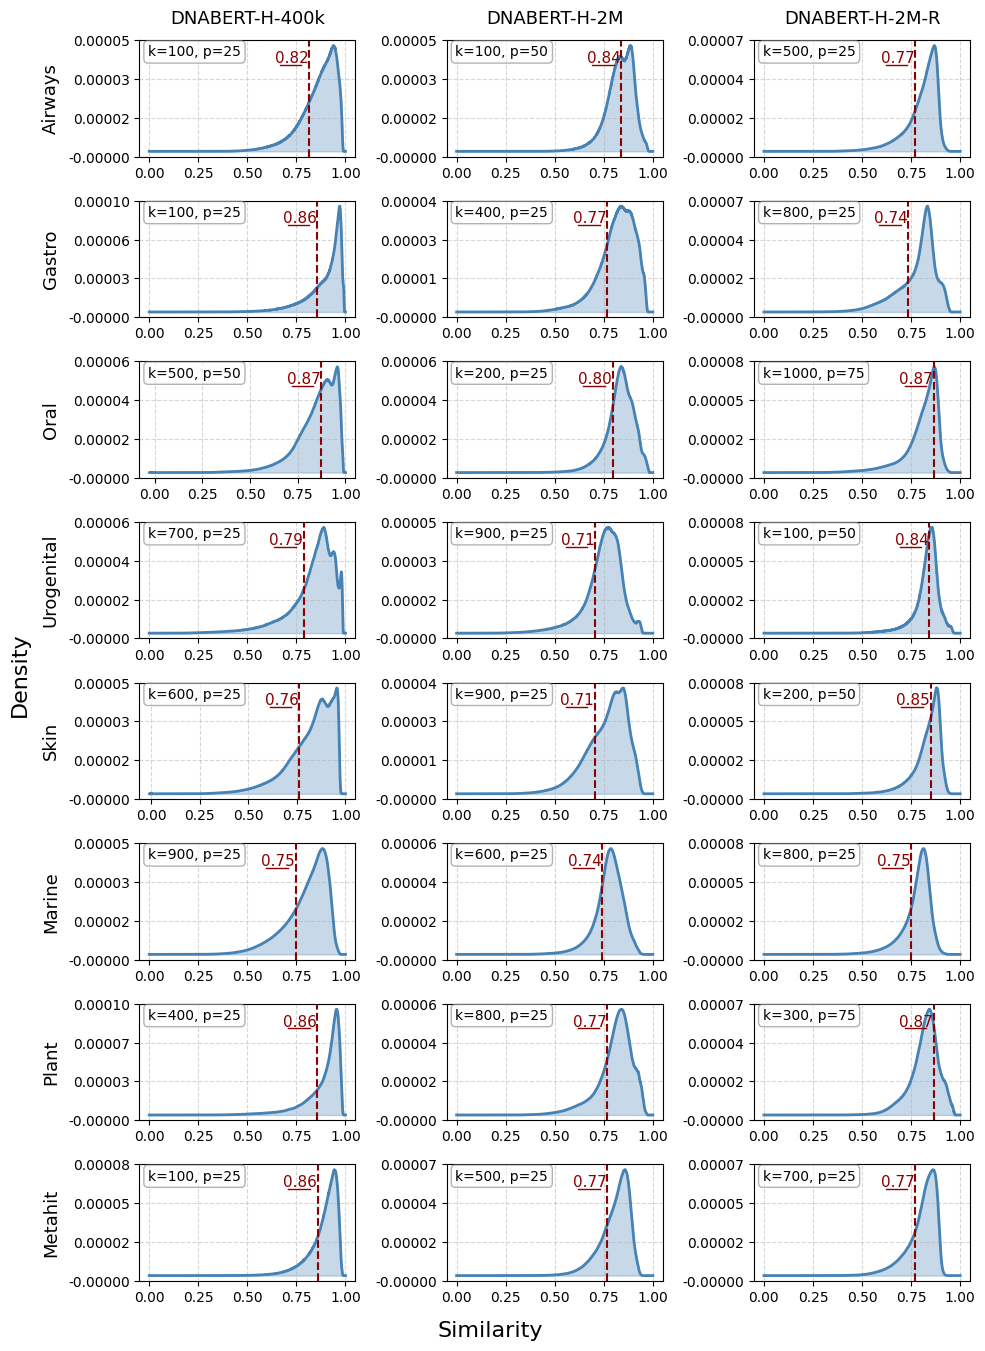

In [92]:
plot_histograms(knn_data, MODELS[:3], MODEL_NAMES[:3], 'histogram_1.svg')

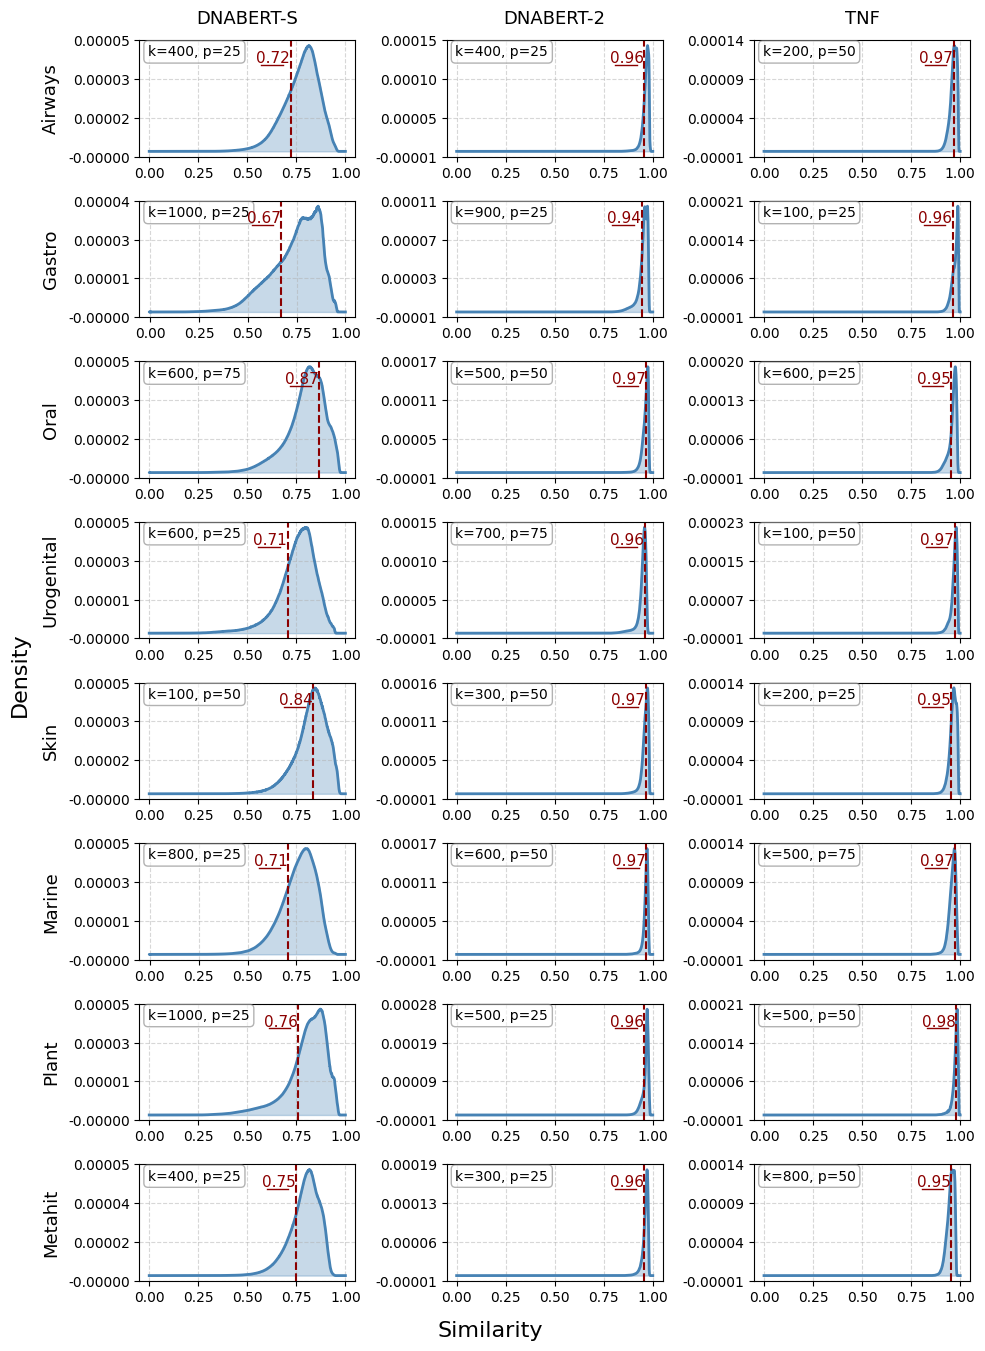

In [93]:
plot_histograms(knn_data, MODELS[3:6], MODEL_NAMES[3:6], 'histogram_2.svg')

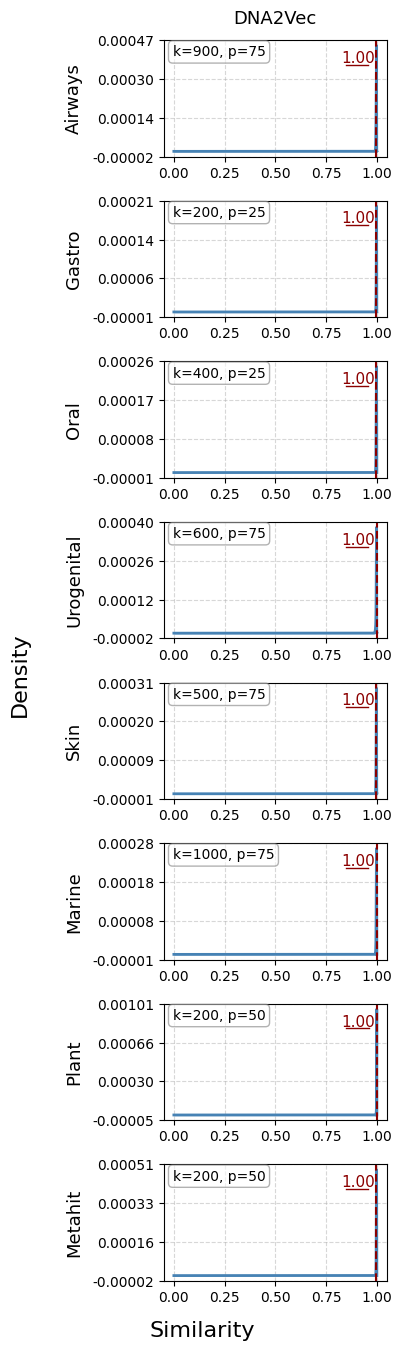

In [94]:
plot_histograms(knn_data, MODELS[6:], MODEL_NAMES[6:], 'histogram_3.svg')

## Heatmaps

In [95]:
model_names_heatmaps = {
    #'vamb': 'VAMB',
    #'taxvamb': 'TaxVAMB',
    #'comebin': 'Comebin',
    #'dnaberth': 'DNABERT-H 400k',
    #'dnaberth_2mv1': 'DNABERT-H 2MV1',
    #'dnaberth_2mv2': 'DNABERT-H 2MV2',
    'dnaberth_400kv2': 'DNABERT-H-400k',
    'dnaberth_2mv4': 'DNABERT-H-2M',
    'dnaberth_2mv5': 'DNABERT-H-2M-R',
    'dnaberts': 'DNABERT-S',
    'dnabert2': 'DNABERT-2',
    #'dnabert2random': 'DNABERT2-Random',
    'tnf': 'TNF',
    #'tnfkernel': 'TNF-Kernel',
    'dna2vec': 'DNA2Vec'
}


In [96]:
heatmaps = pd.read_csv(os.path.join(RESULTS_DIR, 'heatmaps.csv'), sep=',')

In [100]:
def plot_heatmaps(results_df: pd.DataFrame, models_to_plot: list[str], max_plots=8, datasets_to_plot=None):
    """
    For each model in `models_to_plot`, plots up to 8 heatmaps (for datasets) in a 4x2 grid per figure.
    X and Y axes are swapped (K on x-axis, Percentile on y-axis).
    Dataset names are cleaned (_short removed and capitalized).
    """

    if datasets_to_plot is None:
        datasets_to_plot = DATASET_ORDER
    else:
        datasets_to_plot = [ds for ds in DATASET_ORDER if ds in datasets_to_plot]

    results_df['heatmap'] = results_df['heatmap'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )

    for model in models_to_plot:
        print(f"PLOT FOR ------{model}")
        model_df = results_df[(results_df['model'] == model) & (results_df['dataset'].isin(datasets_to_plot))]
        model_df['dataset'] = pd.Categorical(model_df['dataset'], categories=datasets_to_plot, ordered=True)
        model_df = model_df.sort_values('dataset')

        n_plots = min(len(model_df), max_plots)
        n_cols = 4
        n_rows = math.ceil(n_plots / n_cols)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.2 * n_cols, 2.3 * n_rows))
        axes = axes.flatten()

        # Create a new axis for the color bar (to the right of the last plot)
        cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])  # Adjust the position for color bar

        # Find the global min and max for color scale within the model
        min_val = float('inf')
        max_val = float('-inf')

        # Loop through each dataset in the model and calculate the global min and max values
        for _, row in model_df.head(max_plots).iterrows():
            heatmap_dict = row['heatmap']
            df = pd.DataFrame(heatmap_dict)
            df.index = df.index.astype(int)  # Percentiles
            df.columns = df.columns.astype(int)  # Ks

            df = df.sort_index(axis=0, ascending=False)  # Reverse the order of percentiles (Y-axis)
            df = df.sort_index(axis=1)  # K (X-axis)

            # Update min and max values for color scale
            min_val = min(min_val, df.values.min())
            max_val = max(max_val, df.values.max())

        # Loop over each subplot to plot the heatmap with consistent color scale within the model
        for i, (_, row) in enumerate(model_df.head(max_plots).iterrows()):
            heatmap_dict = row['heatmap']
            df = pd.DataFrame(heatmap_dict)
            df.index = df.index.astype(int)  # Percentiles
            df.columns = df.columns.astype(int)  # Ks

            df = df.sort_index(axis=0, ascending=False)  # Reverse the order of percentiles (Y-axis)
            df = df.sort_index(axis=1)  # K (X-axis)

            pretty_name = row['dataset'].replace('_short', '').capitalize()

            # Plot the heatmap for each dataset with consistent color scale within the model
            fmt_func = np.vectorize(lambda x: f"{x:.2f}".lstrip("0") if 0 <= x < 1 else f"{x:.2f}")

            sns.heatmap(
                df.values,
                annot=fmt_func(df.values),
                fmt="",
                cmap="flare",
                cbar=True,
                linewidths=0.5,
                xticklabels=df.columns,
                yticklabels=df.index,
                ax=axes[i],
                cbar_ax=cbar_ax,
                vmin=min_val,
                vmax=max_val
            )
            axes[i].set_title(pretty_name)
            axes[i].tick_params(axis='y', rotation=0)

            # Set Y-axis labels only for the 1st and 5th plot (0-indexed 0 and 4)
            if i != 0 and i != 4:
                axes[i].set_yticklabels([])

            # Set X-axis labels only for the 5th, 6th, 7th, and 8th plot (0-indexed 4, 5, 6, 7)
            if i < 4 or i > 7:
                axes[i].set_xticklabels([])

        # Hide unused subplots
        for j in range(n_plots, len(axes)):
            axes[j].axis('off')

        # Common x and y labels
        fig.suptitle(f"{model_names_heatmaps[model]}", fontsize=15, y=0.92)
        fig.supxlabel("K Neighbors", fontsize=12)
        fig.supylabel("Percentile (P)", fontsize=12, x=0)  # Move the Y-axis label further left
        
        # Adjust layout for common color bar
        plt.tight_layout(rect=[0, 0, 0.9, 0.95])
        plt.savefig(os.path.join(OUT_DIR, "heatmaps_knn", f'{model}.svg'), bbox_inches='tight')
        plt.show()

PLOT FOR ------dnaberth_400kv2


C:\Users\ah140\AppData\Local\Temp\ipykernel_5748\164766390.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['dataset'] = pd.Categorical(model_df['dataset'], categories=datasets_to_plot, ordered=True)
C:\Users\ah140\AppData\Local\Temp\ipykernel_5748\164766390.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


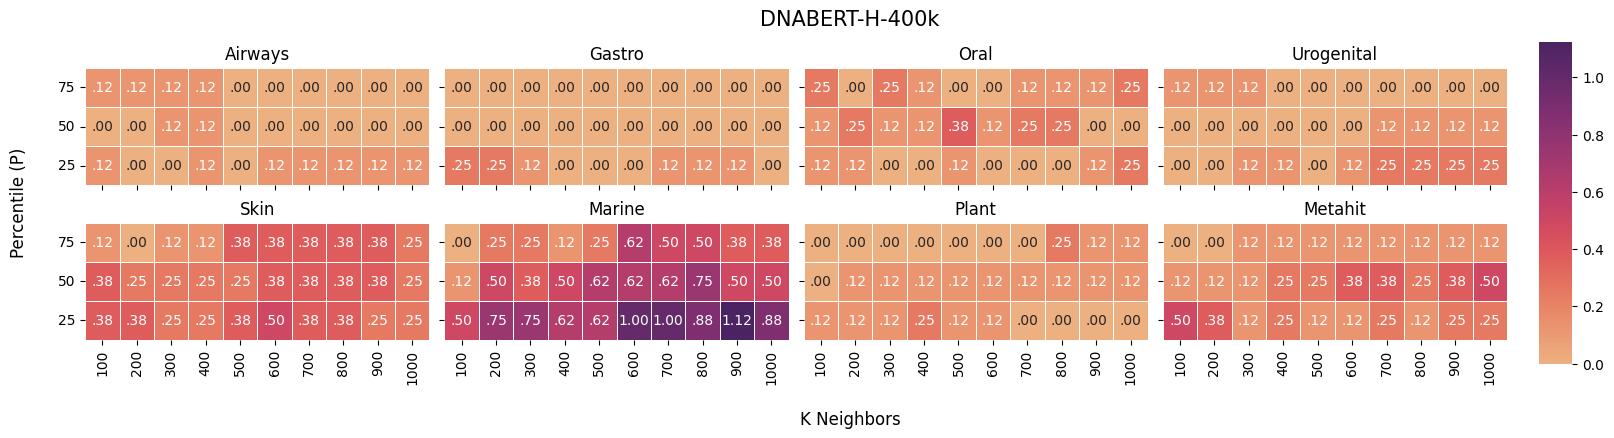

PLOT FOR ------dnaberth_2mv4


C:\Users\ah140\AppData\Local\Temp\ipykernel_5748\164766390.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['dataset'] = pd.Categorical(model_df['dataset'], categories=datasets_to_plot, ordered=True)
C:\Users\ah140\AppData\Local\Temp\ipykernel_5748\164766390.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


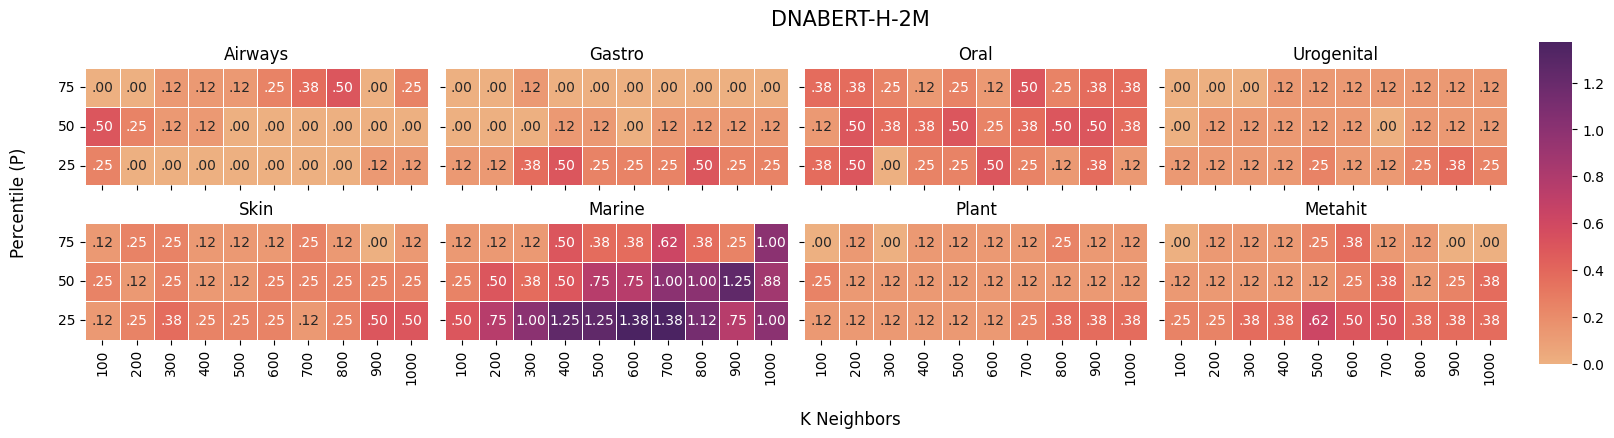

PLOT FOR ------dnaberth_2mv5


C:\Users\ah140\AppData\Local\Temp\ipykernel_5748\164766390.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['dataset'] = pd.Categorical(model_df['dataset'], categories=datasets_to_plot, ordered=True)
C:\Users\ah140\AppData\Local\Temp\ipykernel_5748\164766390.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


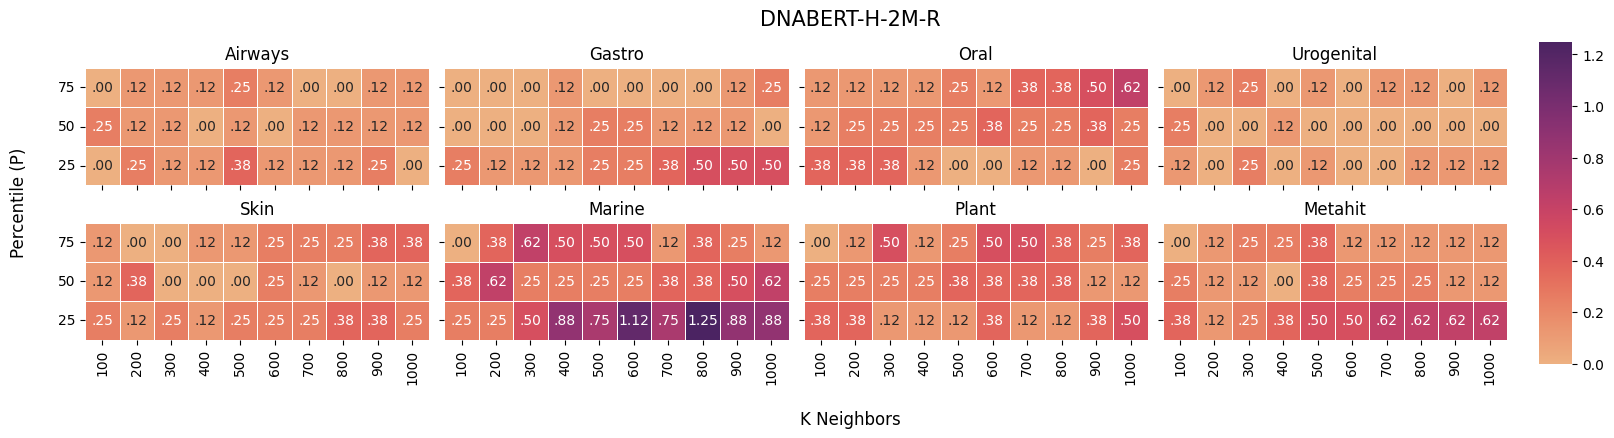

PLOT FOR ------dnaberts


C:\Users\ah140\AppData\Local\Temp\ipykernel_5748\164766390.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['dataset'] = pd.Categorical(model_df['dataset'], categories=datasets_to_plot, ordered=True)
C:\Users\ah140\AppData\Local\Temp\ipykernel_5748\164766390.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


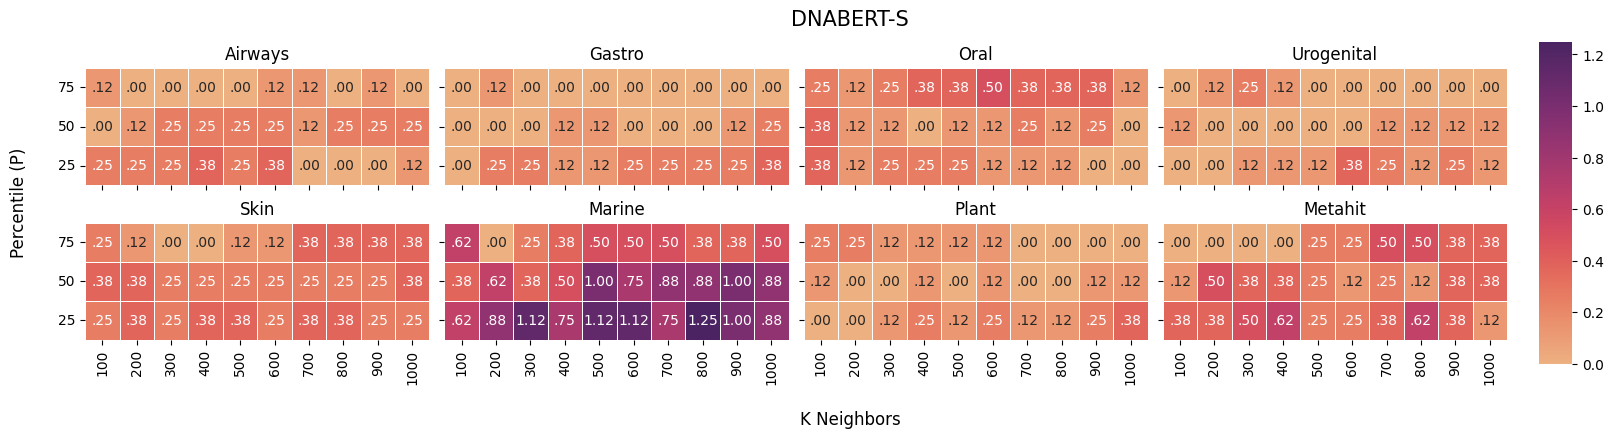

PLOT FOR ------dnabert2


C:\Users\ah140\AppData\Local\Temp\ipykernel_5748\164766390.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['dataset'] = pd.Categorical(model_df['dataset'], categories=datasets_to_plot, ordered=True)
C:\Users\ah140\AppData\Local\Temp\ipykernel_5748\164766390.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


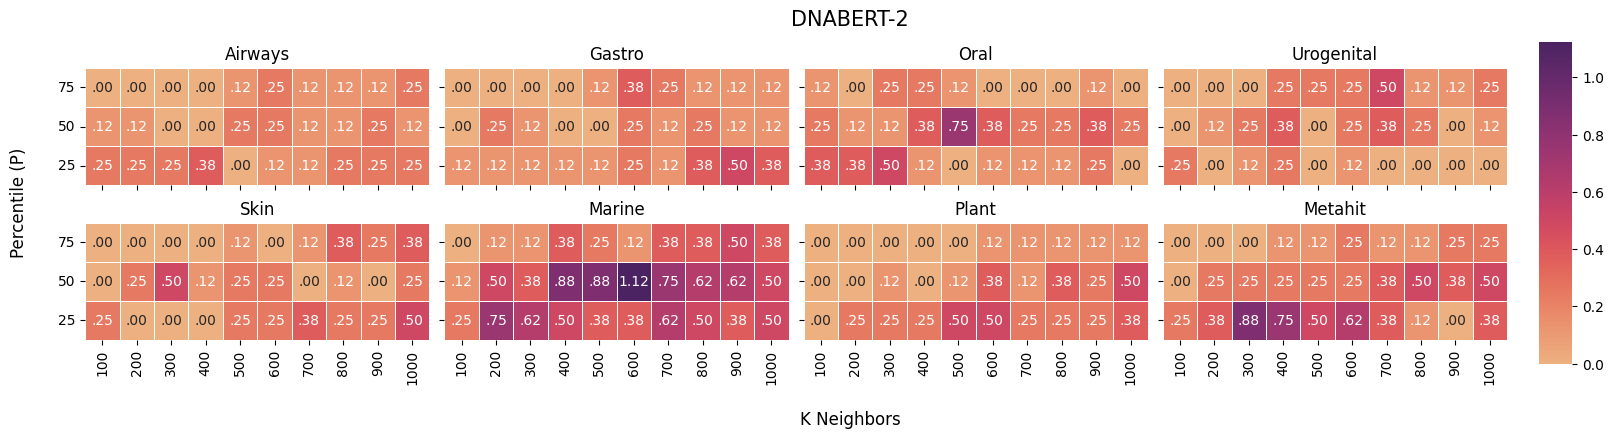

PLOT FOR ------tnf


C:\Users\ah140\AppData\Local\Temp\ipykernel_5748\164766390.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['dataset'] = pd.Categorical(model_df['dataset'], categories=datasets_to_plot, ordered=True)
C:\Users\ah140\AppData\Local\Temp\ipykernel_5748\164766390.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


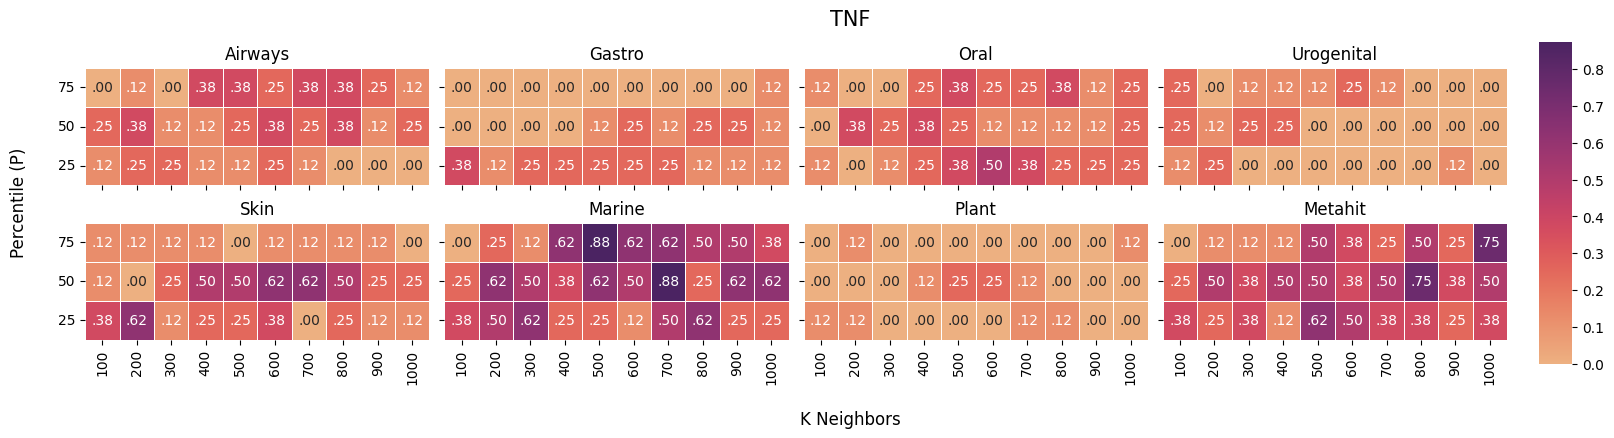

PLOT FOR ------dna2vec


C:\Users\ah140\AppData\Local\Temp\ipykernel_5748\164766390.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['dataset'] = pd.Categorical(model_df['dataset'], categories=datasets_to_plot, ordered=True)
C:\Users\ah140\AppData\Local\Temp\ipykernel_5748\164766390.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


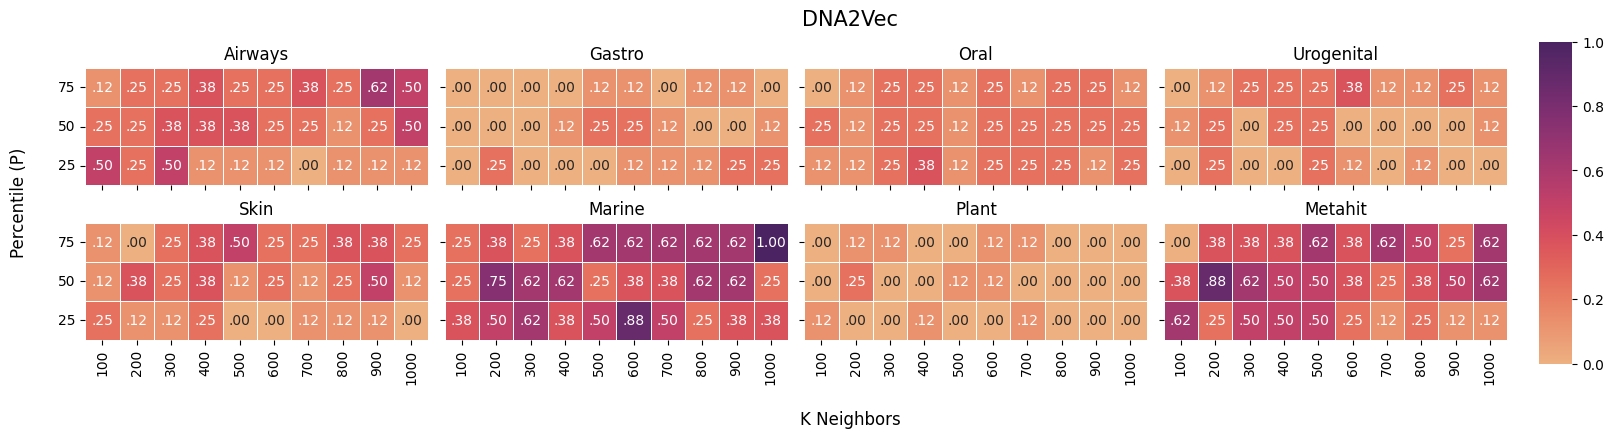

In [101]:
plot_heatmaps(heatmaps, models_to_plot=MODELS)      

## Contig length histograms

In [102]:
with open(os.path.join(RESULTS_DIR, 'parsed_contig_lengths.json'), 'r') as f:
    contig_data_cami2 = json.load(f)
contig_data_cami2 = {key: contig_data_cami2[key] for key in DATASET_ORDER if key in contig_data_cami2}

In [ ]:
with open(os.path.join(RESULTS_DIR, 'parsed_contig_lengths_mil.json'), 'r') as f:
    contig_data_mil = json.load(f)
contig_data_mil = {key: contig_data_mil[key] for key in ['T2D-EW_PRJEB1786', 'UNSEEN_BIO'] if key in contig_data_mil}

In [ ]:
contig_data_all = {**contig_data_cami2, **contig_data_mil}

C:\Users\ah140\AppData\Local\Temp\ipykernel_11048\1757620786.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


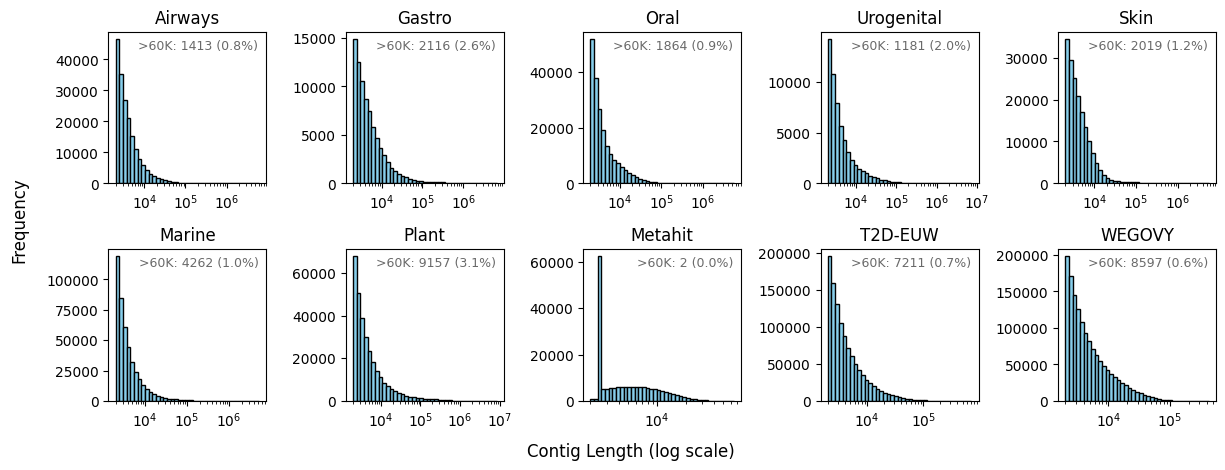

In [14]:
# Parameters
n_cols = 5
n_rows = 2
min_length = 2000
highlight_threshold = 60000  # threshold to count lengths above

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4.5), constrained_layout=True)
axes = axes.flatten()

for idx, (dataset, lengths) in enumerate(contig_data_all.items()):
    ax = axes[idx]
    # Ensure lengths is a numpy array for min/max operations
    arr = np.array(lengths)

    # Compute log-spaced bins
    min_edge = max(arr.min(), min_length)
    max_edge = arr.max()
    bins = np.logspace(np.log10(min_edge), np.log10(max_edge), 40)

    # Plot histogram on log scale
    ax.hist(arr, bins=bins, color='skyblue', edgecolor='black')
    ax.set_xscale('log')

    # Count how many lengths exceed the threshold
    count_above = np.sum(arr >= highlight_threshold)

    if dataset in DATASET_ORDER:
        ax.set_title(dataset.replace('_short', '').capitalize())
    else:
        name_map = {'UNSEEN_BIO': 'WEGOVY', 'T2D-EW_PRJEB1786': 'T2D-EUW'}
        ax.set_title(name_map.get(dataset, dataset))
    # Display count above threshold
    ax.text(
        0.95, 0.95,
        f'>60K: {count_above} ({count_above / len(arr) * 100:.1f}%)',
        ha='right', va='top', transform=ax.transAxes,
        fontsize=9, color='dimgrey'
    )

    # Format ticks: use log ticks
    ax.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=5))
    ax.xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs='auto', numticks=10))
    ax.xaxis.set_minor_formatter(plt.NullFormatter())

# Global labels
fig.text(0.5, -0.015, 'Contig Length (log scale)', ha='center', va='center', fontsize=12)
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'seq_len_hist_log.svg'), bbox_inches='tight')
plt.show()

In [ ]:
# Plot setup
n_cols = 1
n_rows = 2
percentile = 98
min_length = 2000

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for idx, (dataset, lengths) in enumerate(contig_data_mil.items()):
    ax = axes[idx]
    top_1_percentile = np.percentile(lengths, 99)
    top_1_count = sum(l > top_1_percentile for l in lengths)
    print(dataset, top_1_count)
    ax.hist(lengths, bins=40, color='skyblue', range=(min_length, top_1_percentile), edgecolor='black')
    ax.set_title(dataset.replace('_short','').capitalize())
    ax.text(0.95, 0.95, f'Top {100-percentile}%: n={top_1_count}', ha='right', va='top', transform=ax.transAxes, fontsize=9, color='grey') 
    ticks = np.linspace(min_length, top_1_percentile, 4)  
    ticks = np.round(ticks / 1000) * 1000
    ax.set_xticks(ticks)
    
fig.text(0.5, 0.0, 'Contig Length', ha='center', va='center', fontsize=12)  # X-axis label
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', fontsize=12) 

plt.tight_layout()
#plt.savefig(os.path.join(OUT_DIR, 'seq_len_hist.svg'), bbox_inches='tight')
plt.show()

T2D-EW_PRJEB1786 295803


airways_short 1877
gastro_short 817
oral_short 2016
urogenital_short 578
skin_short 1740
marine_short 4391
plant_short 3003
metahit 1796


C:\Users\ah140\AppData\Local\Temp\ipykernel_1600\3995550.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


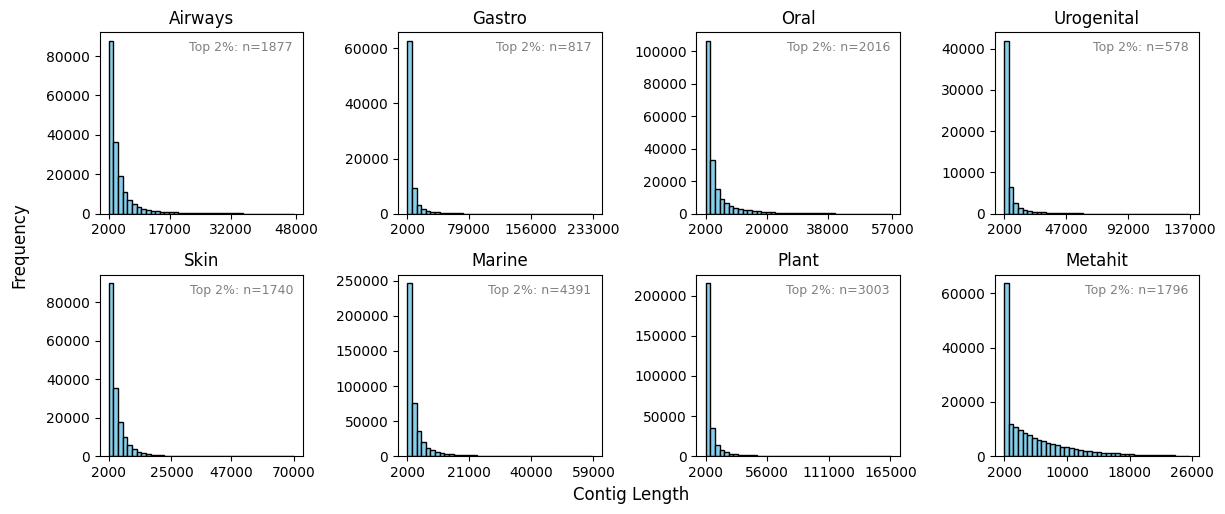

In [ ]:
# Plot setup
n_cols = 4
n_rows = 2
percentile = 98
min_length = 2000

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for idx, (dataset, lengths) in enumerate(contig_data_cami2.items()):
    ax = axes[idx]
    top_1_percentile = np.percentile(lengths, 99)
    top_1_count = sum(l > top_1_percentile for l in lengths)
    print(dataset, top_1_count)
    ax.hist(lengths, bins=40, color='skyblue', range=(min_length, top_1_percentile), edgecolor='black')
    ax.set_title(dataset.replace('_short','').capitalize())
    ax.text(0.95, 0.95, f'Top {100-percentile}%: n={top_1_count}', ha='right', va='top', transform=ax.transAxes, fontsize=9, color='grey') 
    ticks = np.linspace(min_length, top_1_percentile, 4)  
    ticks = np.round(ticks / 1000) * 1000
    ax.set_xticks(ticks)
    
fig.text(0.5, 0.0, 'Contig Length', ha='center', va='center', fontsize=12)  # X-axis label
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', fontsize=12) 

plt.tight_layout()
#plt.savefig(os.path.join(OUT_DIR, 'seq_len_hist.svg'), bbox_inches='tight')
plt.show()

## Agglomorative clustering

In [23]:
PHENO_RESULTS_DIR

'..\\phenotype_mil\\mil_results'

In [6]:
aggd = np.load("agglomorative_dnaberts_T2D-EW_agglomorative_data.npz")
aggl = aggd["labels"]
agge = aggd['embedding']
aggn = aggd["n_clusters"]

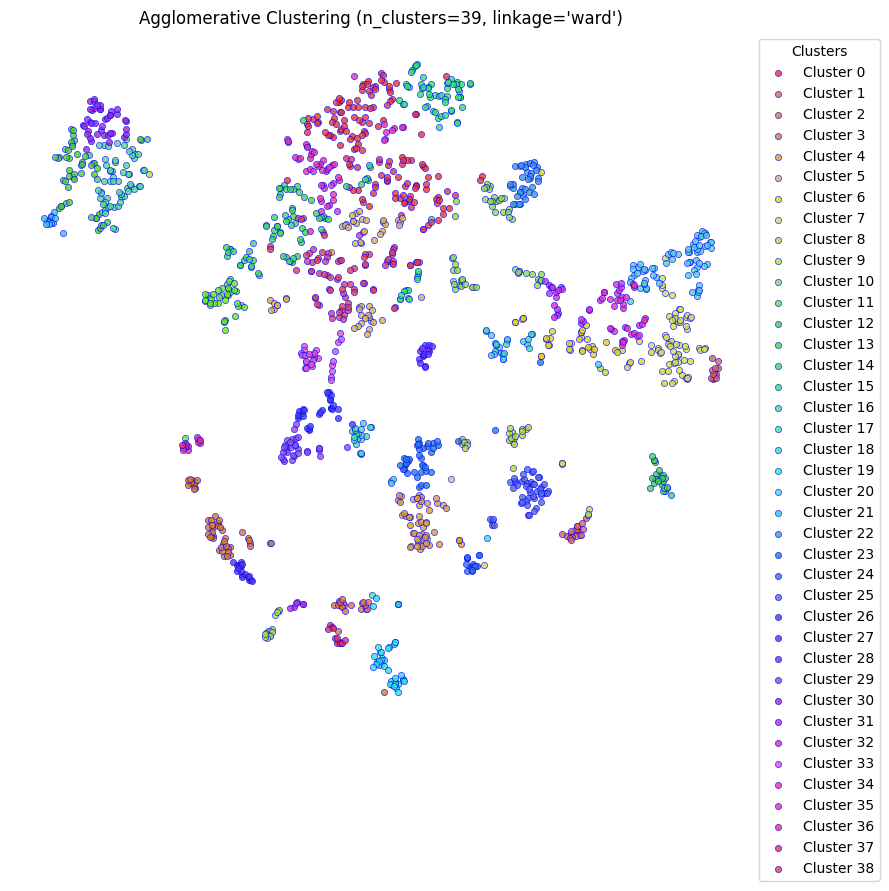

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors as mcolors
from colorsys import hls_to_rgb

def get_distinct_colors(n):
    """
    Generate n visually distinct colors using HLS color space.
    """
    colors = []
    for i in np.linspace(0, 1, n, endpoint=False):
        h = i  # Hue
        l = 0.5 + np.random.rand() * 0.1  # Lightness
        s = 0.6 + np.random.rand() * 0.2  # Saturation
        r, g, b = hls_to_rgb(h, l, s)
        colors.append((r, g, b))
    return colors

# Assuming 'aggl' contains cluster labels and 'agge' contains the 2D t-SNE embeddings
# 'aggn' represents the number of clusters

colors = get_distinct_colors(aggn)

plt.figure(figsize=(9, 9))
ax = plt.gca()

# Plot each cluster with a unique color
for lbl in np.unique(aggl):
    mask = aggl == lbl
    ax.scatter(
        agge[mask, 0],
        agge[mask, 1],
        label=f"Cluster {lbl}",
        s=20,
        alpha=0.8,
        edgecolors='b',
        linewidth=0.5,
        color=colors[lbl]
    )

# Set plot title
ax.set_title(f"Agglomerative Clustering (n_clusters={aggn}, linkage='ward')")

# Remove axis labels and ticks
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])

# Hide all spines (borders)
for spine in ax.spines.values():
    spine.set_visible(False)

# Position the legend outside the plot
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Clusters")

plt.tight_layout()
plt.show()

## T-SNE on Hausdorff Distances with GTDB Labels

In [24]:
BINLOOPUP_DIR = os.path.join('..','phenotype_mil', 'mil_results')
#BINLOOKUP_DATASETS = ['T2D-EW', 'UNSEEN']
BINLOOKUP_DATASETS = ['T2D-EW']
BINLOOPUP_MODELS = ['dnaberts', 'dnaberth_2mv4']

In [25]:
rank_prefixes = {
    'd__': 'domain',
    'p__': 'phylum',
    'c__': 'class',
    'o__': 'order',
    'f__': 'family',
    'g__': 'genus',
    's__': 'species',
}


def split_taxonomy(tax_str):
    # initialize all ranks to NaN
    out = {v: None for v in rank_prefixes.values()}
    for part in tax_str.split(';'):
        for prefix, rank in rank_prefixes.items():
            if part.startswith(prefix):
                out[rank] = part[len(prefix):] or None
                break
    return out

In [26]:
lookup_data = {}

for dataset in BINLOOKUP_DATASETS:
    for model in BINLOOPUP_MODELS:
        print(model)
        path = os.path.join(BINLOOPUP_DIR, dataset, f"{model}_binlookup")
        print(path)
        hausdorff_path = os.path.join(path, f"{model}_{dataset}.npz")
        lookup_path = os.path.join(path, 'gtdbtk.bac120.summary.tsv')
    
        
        hausdorff_npz  = np.load(hausdorff_path)
        hausdorff_dist = hausdorff_npz["distance_matrix"]            
        hausdorff_cluster_names  = hausdorff_npz["cluster_names"]        
        
        binlookup = pd.read_csv(lookup_path, sep="\t")
        binlookup = binlookup.rename(columns={"user_genome": "cluster_names"})
        binlookup['cluster_names'] = binlookup['cluster_names'].astype(str)
        tax_df = binlookup['classification'].apply(split_taxonomy).apply(pd.Series)
        binlookup = pd.concat([binlookup, tax_df], axis=1)
        
        first_two = ["cluster_names", "classification"]  
        tax_ranks = ["domain", "phylum", "class", "order", "family", "genus", "species"]
        rest = [c for c in binlookup.columns
                if c not in first_two + tax_ranks]
        binlookup = binlookup[first_two + tax_ranks + rest]
        
        binlookup = binlookup[~binlookup['classification'].isin(['Unclassified Bacteria', 'Unclassified'])]
    
    
        mask = np.isin(hausdorff_cluster_names, binlookup['cluster_names'].values)
        filtered_names   = hausdorff_cluster_names[mask]
        filtered_matrix  = hausdorff_dist[np.ix_(mask, mask)]
        
        # reorder binlookup to the same filtered order
        binlookup = (
            binlookup
            .set_index("cluster_names")
            .loc[filtered_names]
            .reset_index()
        )
        assert np.array_equal(filtered_names, binlookup["cluster_names"].to_numpy())
        assert len(filtered_names) == filtered_matrix.shape[0] == binlookup.shape[0]

        lookup_data[f"{dataset}_{model}"] = {
            "hausdorff": {
                "distances": filtered_matrix,
                "cluster_names": filtered_names
            },
            "binlookup": binlookup
        }

dnaberts
..\phenotype_mil\mil_results\T2D-EW\dnaberts_binlookup
dnaberth_2mv4
..\phenotype_mil\mil_results\T2D-EW\dnaberth_2mv4_binlookup


In [ ]:
#ranks = ["phylum", "class", "order", "family", "genus"]

Number of clusters in DNABERT-S: 648
DNABERT-S


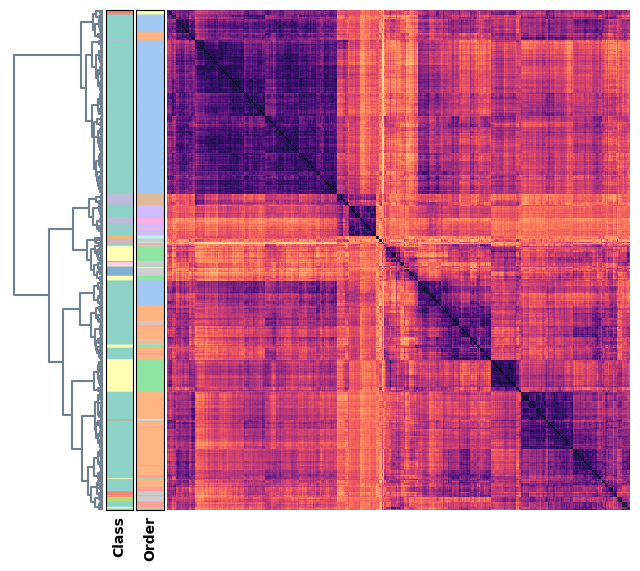

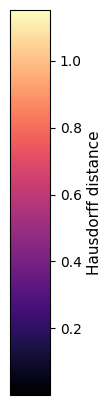

Number of clusters in DNABERT-H-2M: 751
DNABERT-H-2M


KeyboardInterrupt: 

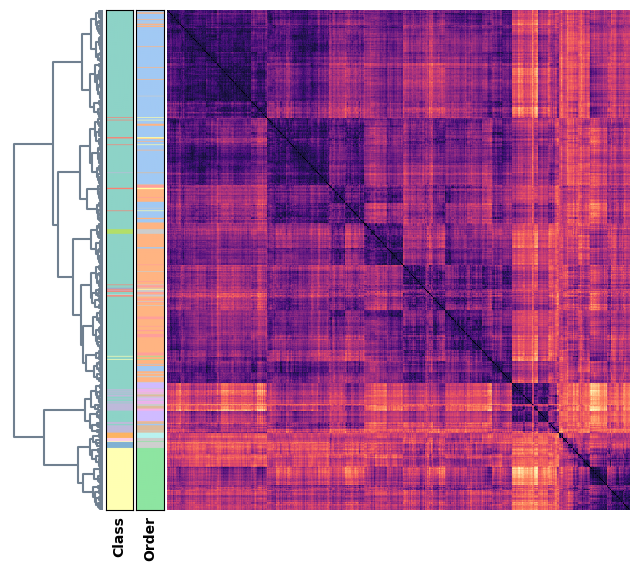

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy as sch
from matplotlib.patches import Patch

# ----------------------------------------
# Configuration
# ----------------------------------------
ranks = ["class", "order"]
rank_palettes = {
    "class": "Set3",
    "order": "pastel"
}

# Map your lookup_data keys to pretty titles
title_map = {
    "T2D-EW_dnaberts": "DNABERT-S",
    "T2D-EW_dnaberth_2mv4": "DNABERT-H-2M",
    # add more key → title mappings here...
}

# ----------------------------------------
# Shared setup: build global_luts & counts
# ----------------------------------------
global_luts = {}
rank_label_counts = {}
for rank in ranks:
    all_labels = []
    for data in lookup_data:
        all_labels.extend(lookup_data[data]["binlookup"][rank].dropna().values)
    cnts = Counter(all_labels)
    rank_label_counts[rank] = cnts
    labels_sorted = [lab for lab,_ in cnts.most_common()]
    pal = sns.color_palette(rank_palettes[rank], n_colors=len(labels_sorted))
    global_luts[rank] = {lab: pal[i] for i, lab in enumerate(labels_sorted)}

# ----------------------------------------
# Plot each dataset separately
# ----------------------------------------
for data_key in lookup_data:
    title = title_map.get(data_key, data_key)
    print(f"Number of clusters in {title}: {lookup_data[data_key]['hausdorff']['distances'].shape[0]}")
    print(title)
    D = lookup_data[data_key]["hausdorff"]["distances"]
    binlookup = lookup_data[data_key]["binlookup"]

    # 1) Hierarchical clustering
    ac = AgglomerativeClustering(
        n_clusters=40, metric='euclidean', linkage='ward',
        compute_full_tree=True, compute_distances=True
    )
    ac.fit(D)

    # 2) Build linkage for dendrogram
    n_leaves = D.shape[0]
    children, dists = ac.children_, ac.distances_
    counts = np.zeros(children.shape[0], dtype=int)
    for i, (l, r) in enumerate(children):
        lc = 1 if l < n_leaves else counts[l - n_leaves]
        rc = 1 if r < n_leaves else counts[r - n_leaves]
        counts[i] = lc + rc
    linkage = np.column_stack([children, dists, counts]).astype(float)

    # 3) Determine top-10 orders for coloring
    top10_orders = [o for o, _ in rank_label_counts["order"].most_common(10)]
    order_lut = {o: global_luts["order"][o] for o in top10_orders}

    # 4) Make figure
    fig = plt.figure(figsize=(8, 6.5))
    gs = fig.add_gridspec(1, len(ranks) + 2,
                          width_ratios=[1] + [0.30]*len(ranks) + [5],
                          wspace=0.02)

    # 5) Dendrogram
    ax_den = fig.add_subplot(gs[0, 0])
    dendro = sch.dendrogram(
        linkage, orientation="left", ax=ax_den,
        no_labels=True, color_threshold=0,
        above_threshold_color="slategrey"
    )
    ax_den.invert_yaxis()
    ax_den.axis("off")
    leaf_order = dendro["leaves"]

    # 6) Taxonomic stripes
    for i, rank in enumerate(ranks):
        vals = binlookup[rank].values[leaf_order]
        if rank == "order":
            colors = [order_lut.get(v, (0.8,0.8,0.8)) for v in vals]
        else:
            lut = global_luts[rank]
            colors = [lut.get(v, (0.9,0.9,0.9)) for v in vals]

        ax_bar = fig.add_subplot(gs[0, i + 1])
        ax_bar.imshow(np.array(colors).reshape(-1, 1, 3), aspect="auto")
        ax_bar.set_xticks([]); ax_bar.set_yticks([])

        ax_bar.set_xlabel(
            rank.capitalize(),
            fontsize=10,
            labelpad=4,
            rotation=90,
            fontweight="bold",
            ha="center"
        )

    # 7) Heatmap (only add colorbar if DNABERT-S)
    ax_hm = fig.add_subplot(gs[0, -1])
    D2 = D[np.ix_(leaf_order, leaf_order)]
    show_cb = (title == "DNABERT-S")
    sns.heatmap(
        D2, ax=ax_hm, cmap="magma",
        xticklabels=False, yticklabels=False,
        cbar=False,
        #cbar_kws={"label": "Hausdorff distance"} if show_cb else {}
    )
    #ax_hm.set_title(title, fontsize=14, fontweight="bold")

    #plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"heat_{title}_.svg"), bbox_inches='tight')
    plt.show()


    if title == "DNABERT-S":
        fig_cb, ax_cb = plt.subplots(figsize=(1.0, 5))  # narrow and tall
        fig_cb.subplots_adjust(left=0.5)

        norm = plt.Normalize(vmin=np.min(D2), vmax=np.max(D2))
        sm = plt.cm.ScalarMappable(cmap="magma", norm=norm)
        sm.set_array([])

        cbar = fig_cb.colorbar(sm, cax=ax_cb, orientation="vertical")
        cbar.set_label("Hausdorff distance", fontsize=11)
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f"heat_legend.svg"), bbox_inches='tight')
        plt.show()
        
    if title == "DNABERT-H-2M":
       for rank in ranks:
            most_common = rank_label_counts[rank].most_common(10)
            labels = [label for label, count in most_common]
            counts = [count for label, count in most_common]

            # Get colors from global LUT, fallback to gray if missing
            lut = global_luts[rank]
            colors = [lut.get(label, (0.9, 0.9, 0.9)) for label in labels]

            # Create legend patches with counts in label
            patches = [
                Patch(color=colors[i], label=f"{labels[i]} ({counts[i]})")
                for i in range(len(labels))
            ]

            # Create separate legend figure
            fig_legend, ax_legend = plt.subplots(figsize=(2, max(2, 0.3 * len(patches))))
            ax_legend.legend(handles=patches, title=f"{rank.capitalize()} colors (top {10})", loc="center")
            ax_legend.axis("off")
            plt.tight_layout()
            plt.show()

In [ ]:
#stress values depending on the initialization, looks at differences between models for different inits and stress

T2D-EW_dnaberts


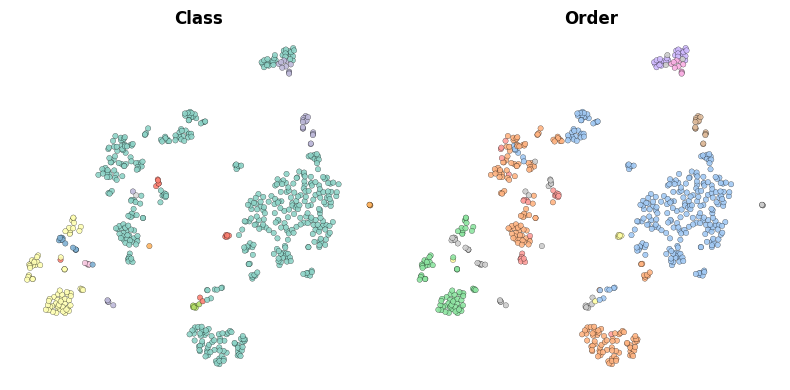

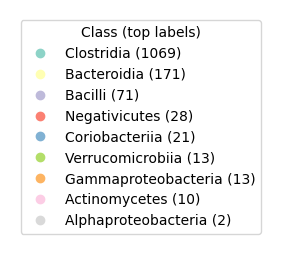

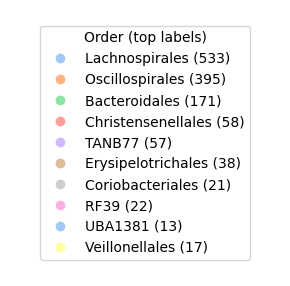

T2D-EW_dnaberth_2mv4


In [ ]:
from sklearn.manifold import TSNE   
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------
# Assuming global_luts, rank_label_counts, ranks defined as before
# ----------------------------------------

for data in lookup_data.keys():
    print(data)
    haus = lookup_data[data]['hausdorff']['distances']
    tsne = TSNE(
        n_components=2,
        metric='precomputed',
        random_state=42,
        perplexity=17,
        init='random'
    )
    tsne_results = tsne.fit_transform(haus)
    
    binlookup = lookup_data[data]["binlookup"]
    
    fig, axes = plt.subplots(1, len(ranks), figsize=(8, 4))
    
    # Store handles and labels for separate legend plotting
    legend_handles = {}

    for ax, rank in zip(axes, ranks):
        vals = binlookup[rank]
        
        if rank == "order":
            # pick top-10 orders by count
            top10 = vals.value_counts().index[:10]
            lut_full = global_luts[rank]
            lut = {o: lut_full[o] for o in top10}
            colors = [lut.get(v, (0.8, 0.8, 0.8)) for v in vals]

            handles = [
                plt.Line2D([], [], marker='o', linestyle='', 
                           color=lut[o], label=f"{o} ({rank_label_counts[rank][o]})")
                for o in top10
            ]
        else:
            sorted_cats = vals.value_counts().index.tolist()
            lut = global_luts[rank]
            colors = [lut[v] for v in vals]
            handles = [
                plt.Line2D([], [], marker='o', linestyle='',
                           color=lut[cls], label=f"{cls} ({rank_label_counts[rank][cls]})")
                for cls in sorted_cats
            ]
        
        ax.scatter(
            tsne_results[:, 0],
            tsne_results[:, 1],
            c=colors,
            s=15,
            alpha=0.9,
            edgecolor='black',
            linewidth=0.2
        )
        ax.set_title(rank.capitalize(), fontsize=12, fontweight='bold')
        ax.set_xticks([]); ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)

        # Save handles for later legend plot
        legend_handles[rank] = handles
    
    #fig.suptitle(f"{data}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"tsne_{data}_.png"), bbox_inches='tight')
    plt.show()
    
    # Now plot legends separately after main plot
    for rank in ranks:
        fig_legend, ax_legend = plt.subplots(figsize=(3, max(2, 0.3*len(legend_handles[rank]))))
        ax_legend.legend(handles=legend_handles[rank], title=f"{rank.capitalize()} (top labels)", loc='center')
        ax_legend.axis('off')
        plt.tight_layout()
        plt.show()
        